## Part2
- Word2Vec을 통해 단어를 벡터화
- t-SNE를 통해 벡터화 한 데이터를 시각화
- 딥러닝 + (supervised) 랜덤 포레스트

### Word2Vec
- One-hot encoding 혹은 Bag of Word에서는 feature가 전체 문서에 나타나는 단어여서 vector size가 매우커서 희소한 행렬이 생성된다(sparse)
- 주위 단어가 비슷하면 해당 단어의 의미는 유사하다
- 단어의 의미를 내포한 dense vector로 매칭
- 장점 : 단어를 벡터화 했을 때, 단어간의 의미를 잃지 않는다.

**CBOW (Continuous Bag of Words)**
- 전체 텍스트로 하나의 단어를 예측하기 때문에 작은 데이터 셋일수록 유리하다.

**Skip-Gram**
- 타켓 단어들로부터 원본 단어를 역으로 예측하는 것. CBoW와 반대 개념. 큰 데이터셋일 때 유리

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('data/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

In [3]:
test = pd.read_csv('data/testData.tsv', header=0, delimiter='\t', quoting=3)

In [6]:
unlabled_train = pd.read_csv('data/unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

In [7]:
print(train.shape)
print(test.shape)
print(unlabled_train.shape)

(25000, 3)
(25000, 2)
(50000, 2)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB


In [10]:
unlabled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
id        50000 non-null object
review    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB


---

## 텍스트 정제과정 클래스

In [24]:
import pandas as pd
import numpy as np
import re

from bs4 import BeautifulSoup as bs
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from multiprocessing import Pool

class Preprocessing(object):
    
    @staticmethod
    def review_to_wordlist(review, remove_stopwords=False):
        # 1. HTML 제거
        review_text = bs(review, "html.parser").get_text()
        # 2. 특수문자를 공백으로 바꿔줌
        review_text = re.sub('[^a-zA-Z]', ' ', review_text)
        # 3. 소문자로 변환 후 나눈다
        words = review_text.lower().split()
        # 4. 불용어 제거
        if remove_stopwords:
            stops = set(stopwords.words('english'))
            words = [w for w in words if not w in stops]
        # 5. 어간추출
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]
        # 6. 리스트 형태로 반환
        return words
    
    def review_to_join_words( review, remove_stopwords=False ):
        words = Preprocessing.review_to_wordlist(\
            review, remove_stopwords=False)
        join_words = ' '.join(words)
        return join_words

    @staticmethod
    def review_to_sentences( review, remove_stopwords=False ):
        # punkt tokenizer를 로드한다.
        """
        이 때, pickle을 사용하는데
        pickle을 통해 값을 저장하면 원래 변수에 연결 된 참조값 역시 저장된다.
        저장된 pickle을 다시 읽으면 변수에 연결되었던
        모든 레퍼런스가 계속 참조 상태를 유지한다.
        """
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        # 1. nltk tokenizer를 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
        raw_sentences = tokenizer.tokenize(review.strip())
        # 2. 각 문장을 순회한다.
        sentences = []
        for raw_sentence in raw_sentences:
            # 비어있다면 skip
            if len(raw_sentence) > 0:
                # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
                sentences.append(\
                    Preprocessing.review_to_wordlist(\
                    raw_sentence, remove_stopwords))
        return sentences


    # 참고 : https://gist.github.com/yong27/7869662
    # http://www.racketracer.com/2016/07/06/pandas-in-parallel/
    # 속도 개선을 위해 멀티 스레드로 작업하도록
    @staticmethod
    def _apply_df(args):
        df, func, kwargs = args
        return df.apply(func, **kwargs)

    @staticmethod
    def apply_by_multiprocessing(df, func, **kwargs):
        # 키워드 항목 중 workers 파라메터를 꺼냄
        workers = kwargs.pop('workers')
        # 위에서 가져온 workers 수로 프로세스 풀을 정의
        pool = Pool(processes=workers)
        # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
        result = pool.map(Preprocessing._apply_df, [(d, func, kwargs)
                for d in np.array_split(df, workers)])
        pool.close()
        # 작업 결과를 합쳐서 반환
        return pd.concat(result)

In [15]:
Preprocessing.review_to_wordlist(train['review'][0])[:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [25]:
sentences = []
for review in train['review']:
    sentences += Preprocessing.review_to_sentences(
            review, remove_stopwords=False)

C:\Program Files\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Program Files\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Program Files\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [27]:
len(sentences)

266551

In [28]:
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [29]:
sentences[1][:10]

['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into']

---

## Gensim을 통해 벡터화 & t-SNE로 시각화
- 다운샘플링 : 문자 빈도수를 다운 샘플링
- context (문자열 창크기) : 10이 적당 

In [33]:
import logging
logging.basiscConfig(
    format = '%(asctime)s : %(levelname)s : %(message)s' ,
    level=logging.INFO)

AttributeError: module 'logging' has no attribute 'basiscConfig'

In [34]:
num_features = 300 # 문제 벡터 차원수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 0.001 # 문자 빈도수 다운 샘플링

# 초기화 밈ㅊ 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences,
                         workers=num_workers,
                         min_count=min_word_count,
                         window=context,
                         sample=downsampling)

model

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [35]:
# 학습이 완료되면 필요없는 메모리를 unload 시킨다
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
model.save(model_name)

### 모델 결과 탐색

In [36]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child dog kitchen'.split())

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'kitchen'

In [40]:
model.wv.doesnt_match('france england germany seoul'.split())

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'england'

In [41]:
# 가장 유사한 단어를 추출
model.wv.most_similar('man')

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.6877942085266113),
 ('doctor', 0.6501785516738892),
 ('millionair', 0.5819971561431885),
 ('scientist', 0.5710203647613525),
 ('boy', 0.5614073872566223),
 ('priest', 0.5531551241874695),
 ('cop', 0.544971227645874),
 ('lad', 0.5405856370925903),
 ('lunat', 0.5369768738746643),
 ('son', 0.5322171449661255)]

In [42]:
model.wv.most_similar('queen')

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('princess', 0.7219850420951843),
 ('garden', 0.701970100402832),
 ('maria', 0.6993720531463623),
 ('aunt', 0.6989911198616028),
 ('widow', 0.6965649127960205),
 ('mari', 0.6957512497901917),
 ('victoria', 0.6941251754760742),
 ('barbara', 0.6911256909370422),
 ('sophi', 0.6830516457557678),
 ('salli', 0.6734785437583923)]

In [43]:
model.wv.most_similar('film')

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('movi', 0.8965116739273071),
 ('pictur', 0.6617971062660217),
 ('flick', 0.6313050389289856),
 ('documentari', 0.6077410578727722),
 ('cinema', 0.5586243271827698),
 ('product', 0.5493963956832886),
 ('masterpiec', 0.5414820909500122),
 ('sequel', 0.5369706153869629),
 ('effort', 0.5227215886116028),
 ('thriller', 0.5090602040290833)]

In [44]:
model.wv.most_similar('happi')

C:\Program Files\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bitter', 0.5153392553329468),
 ('sad', 0.4494248628616333),
 ('famili', 0.4311772882938385),
 ('toward', 0.4112822413444519),
 ('comfort', 0.40819990634918213),
 ('joy', 0.4081868529319763),
 ('happili', 0.4053078889846802),
 ('afraid', 0.4036470353603363),
 ('unhappi', 0.4025495648384094),
 ('parent', 0.395660936832428)]

## Word2Vec으로 벡터화 한 단어를 t-SNE를 통해 시각화

In [45]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim
import gensim.models as g

In [46]:
mpl.rcParams['axes.unicode_minus'] = False
model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])

6517
[-0.20321673  0.01107118 -0.12333276  0.14312714  0.01555523  0.03887697
 -0.10059346  0.22738764 -0.05620828 -0.03871932]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [49]:
tsne = TSNE(n_components=2)

#100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100, :])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


In [51]:
df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
df.shape

(100, 2)

In [52]:
# 아래의 단어들이 x,y 축의 위치에 있다.
df.head()

,x,y
with,67.392006,39.754055
all,17.306162,-34.317806
this,18.574541,-15.834665
stuff,-7.362743,-16.831871
go,-6.368433,41.838928


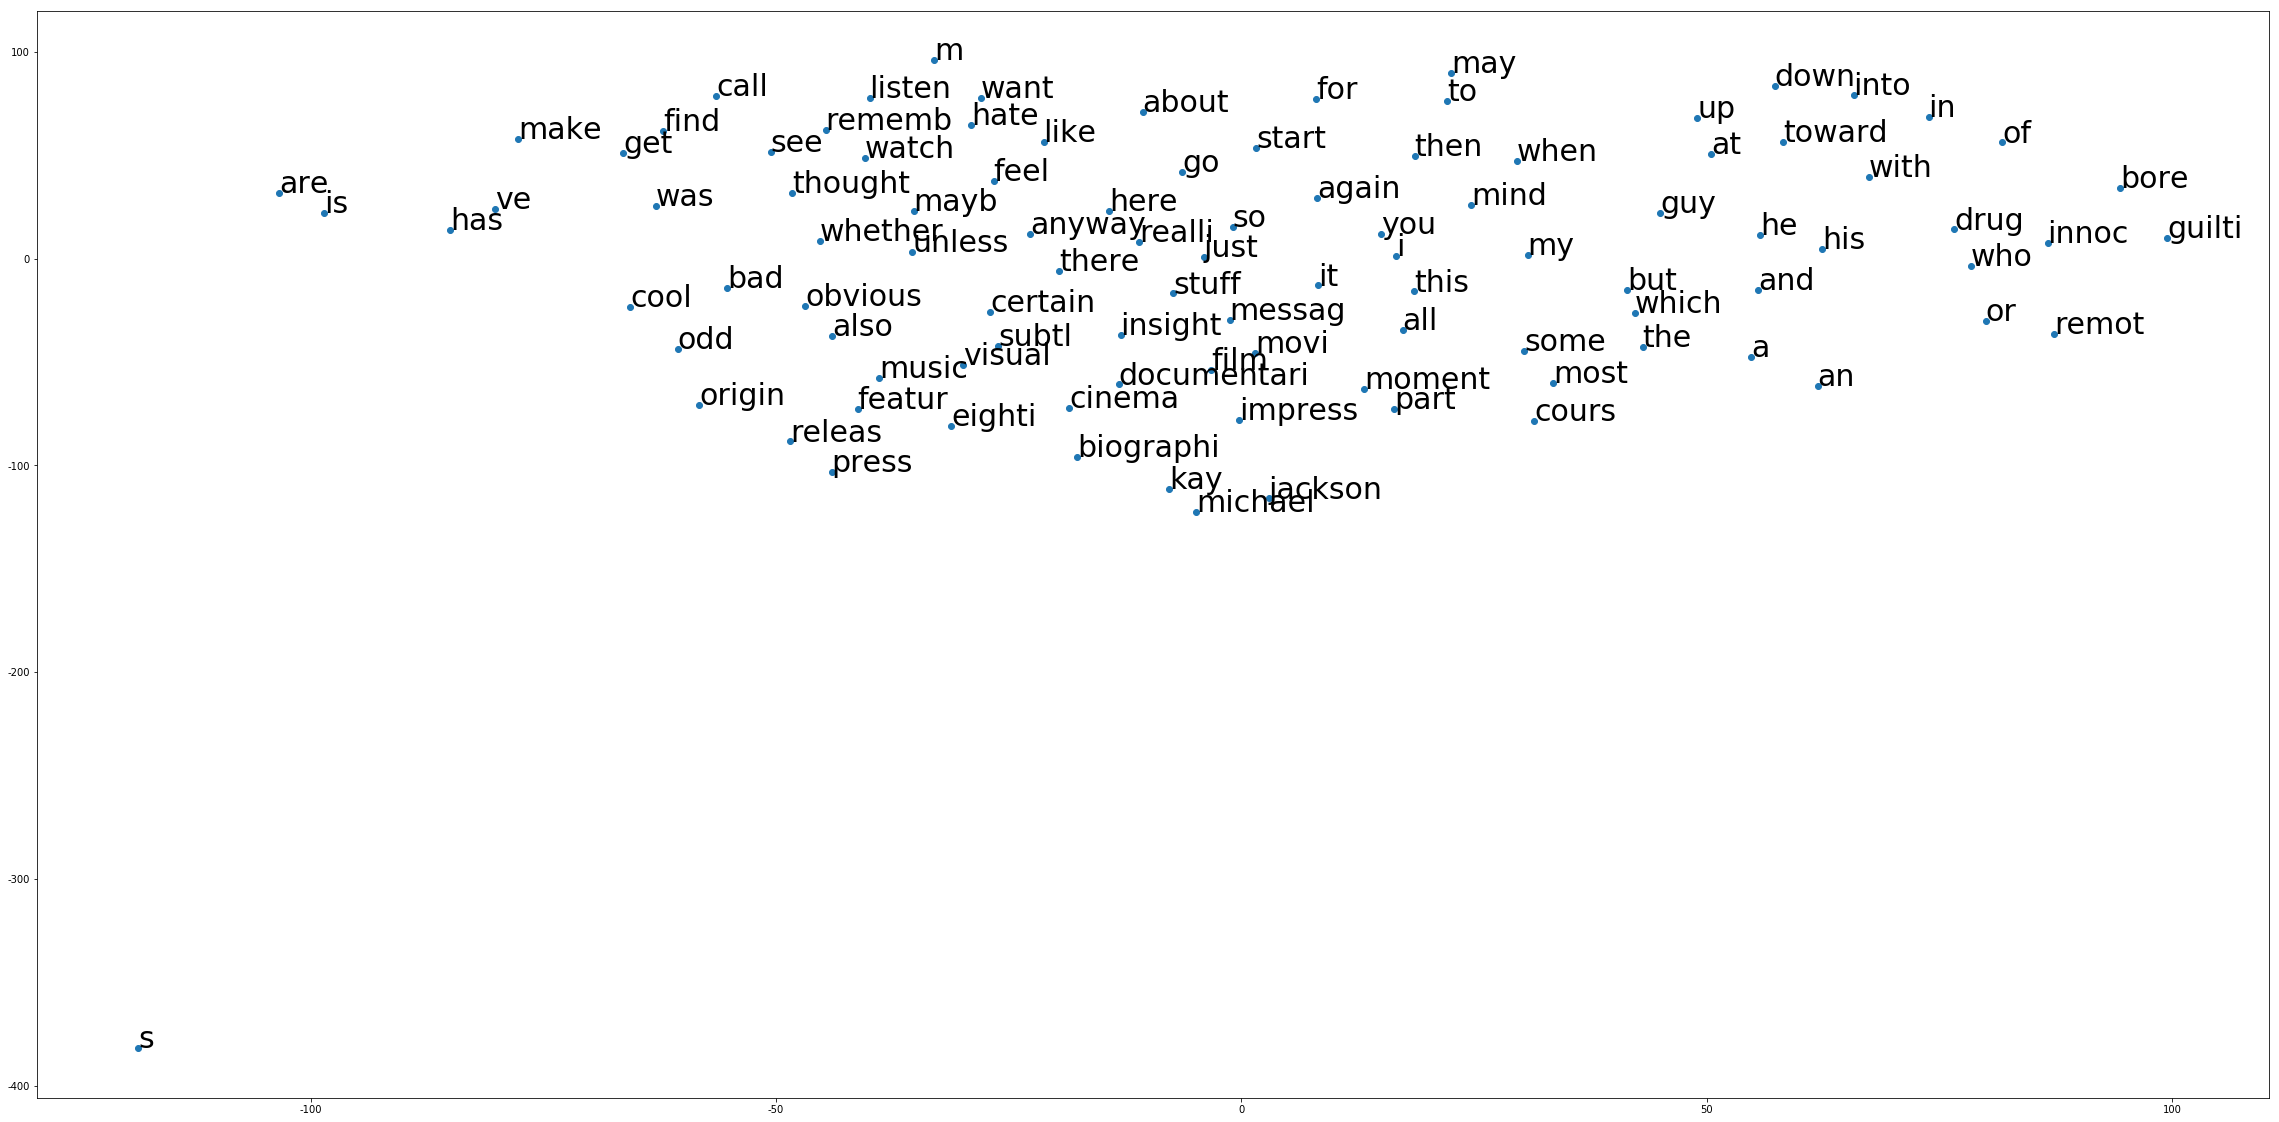

In [54]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()